In [63]:
import sys
import os
sys.path.append(os.path.abspath(".."))


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
from IPython.display import display as disp

import numpy as np
import numpy.ma as ma
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]


# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, plotting, modeleval

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn import model_selection
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = True  

# The data

`x` indicates activity, partitioned into eight quarters, for the four channels ABCD.
`y` indicates movement.

In [9]:
data_path = '../../allan_data/DataPredictMovement_half.p'

In [10]:
x, y = np.load(data_path) 

In [13]:
columns=[f"{com}{qrt}" for com in "call sms gps bt".split() for qrt in range(1, 9)] 
dfx = pd.DataFrame(x, columns=columns)

Plotting the average value of the `x`-vectors, we see that every first quarter of an lower amound of activity. This could reflect human behaviour, because events often start on an hourly basis, or it could be a binning problem.

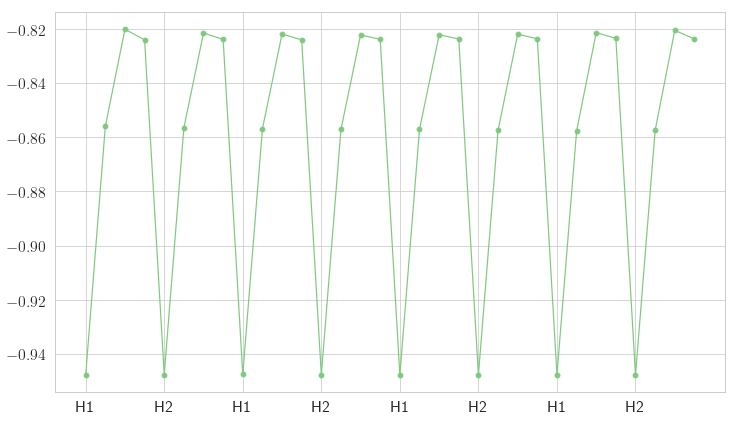

In [5]:
fig, ax = plt.subplots()
ax.plot(x.mean(axis=0), 'o-', c=colorcycle[0])
# xticks = np.array([np.array([0, 3]) + (i*4) for i in range(0, 8)]).ravel()
xticks = np.arange(0, 32, 4)
ax.set_xticks(xticks)
ax.set_xticklabels(["H1", "H2"]*4);
fig.savefig('figs/quarters_value.pdf')

Below is the average of the four quarters in an hour. The same effect with low counts in the first quarter is seen.

In [6]:
means = np.zeros(4)
base_idx = np.arange(0, 32, 4)
for i in range(4):
    idx = base_idx + i
    icut = min(base_idx[-1]+i, x.shape[1])
    idx = idx[idx <= icut]
    arr = x[:, base_idx + i]
    means[i] = arr.mean()
    print("%.3f" % means[i])


-0.948
-0.857
-0.821
-0.824


In [7]:
np.savetxt('quarterly_averages_accross_all_channels.txt', means)

Heatmap of the correlation shows the same pattern... perhaps a dimmensionality reduction is in order, since the intrinsic dimmension of the data might be quite a bit smaller than the current dimmensionalty.

In [7]:
sample_idx = np.random.choice(range(len(y)), len(y)//25) 
dfs = pd.DataFrame(x[sample_idx, :])
corr = dfs.corr() 

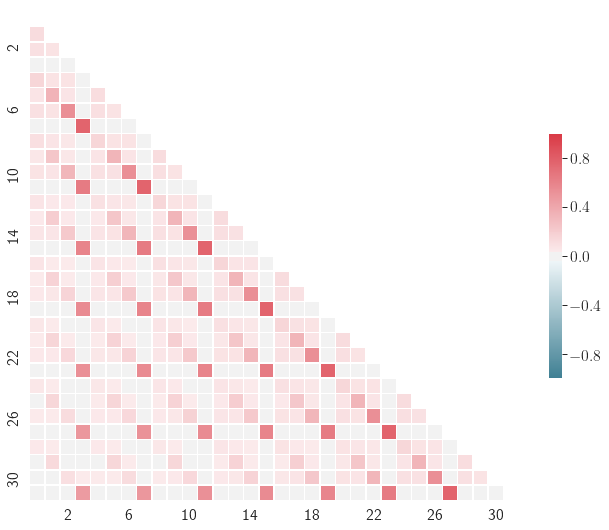

In [8]:
with sns.axes_style("white"):  # ticks
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    # ticks = [str(i) if (i % 2 == 1) else ' ' for i in range(32)]
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) 
    for lx, ly in zip(ax.get_xticklabels()[::2], ax.get_yticklabels()[::2]):
        lx.set_visible(False)
        ly.set_visible(False) 
    
    fig.savefig("figs/quarters_correlations.pdf") 

In [9]:
pca = PCA() 
pca.fit(x)
xx = pca.transform(x)

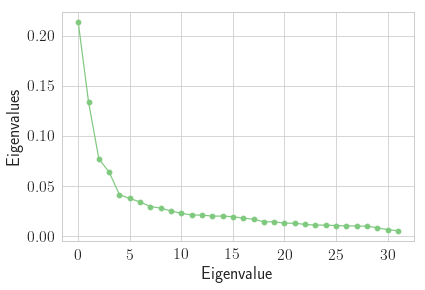

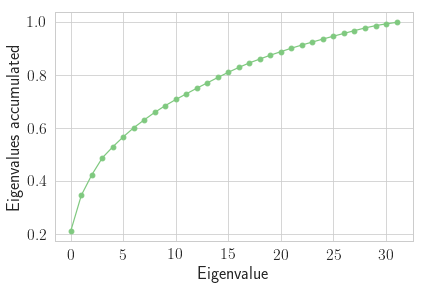

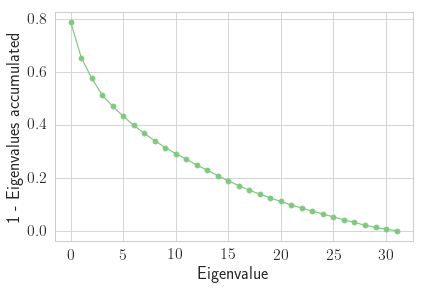

In [10]:
fig, ax = plt.subplots() 
ax.set_ybound(-0.05, 0.25)
ax.plot(pca.explained_variance_ratio_, 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues')
plt.tight_layout() 
fig.subplots_adjust(left=0.15, bottom=0.15)
fig.savefig('figs/pca_eigenvalues_userMovement.pdf')

fig, ax = plt.subplots()
ax.set_ybound(-0.05, 1.05)
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues accumulated')
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('figs/pca_eigenvalues_accumulated_userMovement.pdf')

fig, ax = plt.subplots()
ax.set_ybound(-0.05, 1.05)
ax.plot(1 - np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('1 - Eigenvalues accumulated')
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('figs/pca_eigenvalues_scree_userMovement.pdf')

# Results of the cross validation

Plotting and listing results

In [3]:
with open('./best_estimator_from_cv.pkl', 'br') as fid:
    est = pickle.load(fid) 

In [4]:
cvr = pd.DataFrame(est.cv_results_)

cvr.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_pca__n_components,...,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,65.972342,2.884502,0.783393,0.783393,2,...,0.783591,6.121090,0.581259,0.000327,0.000300
1,74.246537,3.270083,0.783609,0.783605,2,...,0.783807,7.074297,1.195580,0.000294,0.000219
2,74.916792,3.261810,0.488047,0.488018,2,...,0.704737,5.956657,0.420550,0.205912,0.205793
3,82.048790,2.585019,0.500000,0.500000,2,...,0.500000,12.620189,0.594526,0.000000,0.000000
4,95.049002,2.999349,0.785621,0.785618,2,...,0.785705,6.386081,0.548141,0.000379,0.000087


In [5]:
print(*cvr.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_pca__n_components
param_sgd__alpha
param_sgd__loss
param_sgd__penalty
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


In [6]:
cvr.param_sgd__loss.value_counts() 

perceptron        608
squared_hinge     608
modified_huber    608
hinge             608
log               608
Name: param_sgd__loss, dtype: int64

In [7]:
cvr.param_sgd__penalty.value_counts() 

elasticnet    1520
l2            1520
Name: param_sgd__penalty, dtype: int64

In [8]:
cvr.param_pca__n_components.value_counts() 

30    160
10    160
3     160
4     160
5     160
6     160
7     160
8     160
9     160
11    160
27    160
12    160
13    160
14    160
15    160
18    160
21    160
24    160
2     160
Name: param_pca__n_components, dtype: int64

In [9]:
cvr.param_sgd__alpha.value_counts() 

128.000000    190
64.000000     190
4.000000      190
32.000000     190
2.000000      190
16.000000     190
1.000000      190
8.000000      190
0.500000      190
0.250000      190
0.125000      190
0.062500      190
0.031250      190
0.015625      190
0.007812      190
0.003906      190
Name: param_sgd__alpha, dtype: int64

In [13]:
gb = cvr.groupby([cvr.param_pca__n_components, cvr.param_sgd__alpha])

In [14]:
gb = gb.mean_test_score.mean().T  # .unstack() 

In [15]:
tmp = cvr.loc[:, ['param_sgd__alpha', 'param_pca__n_components']] 
tmp.head() 

,param_sgd__alpha,param_pca__n_components
0,0.00390625,2
1,0.00390625,2
2,0.00390625,2
3,0.00390625,2
4,0.00390625,2


In [10]:
gb = cvr.groupby(['param_pca__n_components', 'param_sgd__alpha']).mean_test_score.mean()
gb.head() 

param_pca__n_components  param_sgd__alpha
2                        0.003906            0.684807
                         0.007812            0.709326
                         0.015625            0.711017
                         0.031250            0.687253
                         0.062500            0.678389
Name: mean_test_score, dtype: float64

In [11]:
gbu = gb.T.unstack() 
gbu.head() 

param_sgd__alpha,0.00390625,0.0078125,0.015625,0.03125,0.0625,...,8.0,16.0,32.0,64.0,128.0
param_pca__n_components,,,,,,,,,,,
2,0.684807,0.709326,0.711017,0.687253,0.678389,...,0.612663,0.612648,0.642375,0.642251,0.642136
3,0.713767,0.719039,0.681149,0.664596,0.708271,...,0.614594,0.621256,0.646977,0.646969,0.646937
4,0.723066,0.750491,0.734130,0.757811,0.775448,...,0.636168,0.653681,0.661065,0.661037,0.660860
5,0.763359,0.736126,0.720062,0.744553,0.754267,...,0.643980,0.641665,0.661259,0.661014,0.660816
6,0.759582,0.745448,0.745960,0.732306,0.728461,...,0.632742,0.645988,0.661150,0.660995,0.660907


In [18]:
gbu.columns.name = 'alpha'
gbu.index.name = 'pca components'

In [19]:
with open('my_cubehelix.pkl', 'br') as fid:
    cubehelixcm = pickle.load(fid) 

In [20]:
xlabels = ['$\\frac{1}{256}$',
 '$\\frac{1}{128}$',
 '$\\frac{1}{64}$',
 '$\\frac{1}{32}$',
 '$\\frac{1}{16}$',
 '$\\frac{1}{8}$',
 '$\\frac{1}{4}$',
 '$\\frac{1}{2}$',
 '1',
 '2',
 '4',
 '8',
 '16',
 '32',
 '64',
 '128'] 

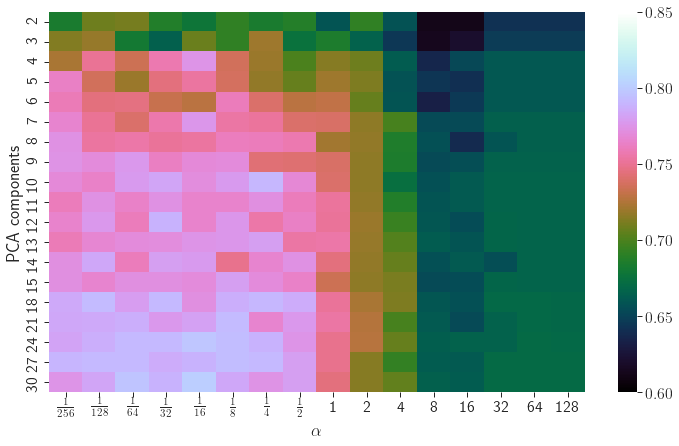

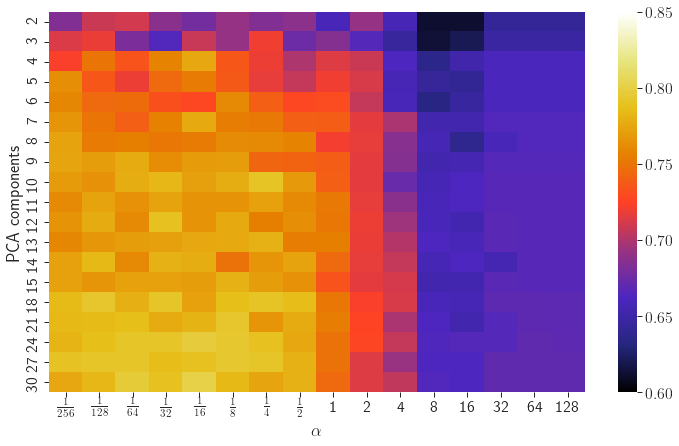

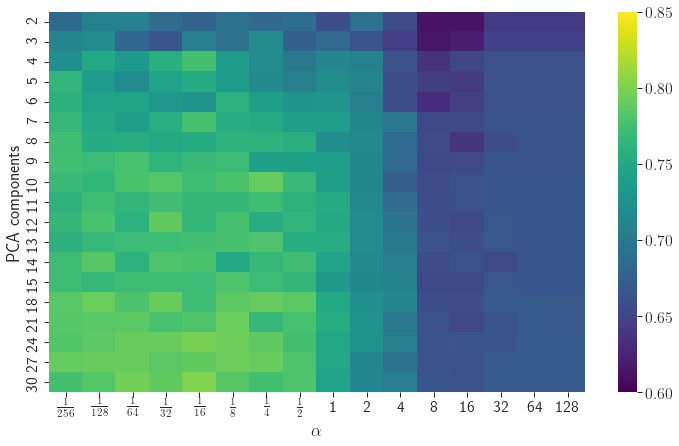

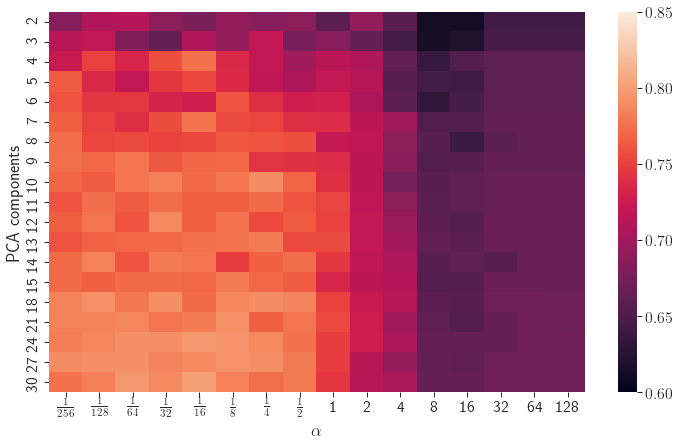

In [21]:

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=[12, 7])
    vmin = 0.6
    vmax = 0.85
    sns.heatmap(gbu, ax=ax, vmin=vmin, vmax=vmax, cmap=cubehelixcm)  # cubehelix, afmhot
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('PCA components')
    ax.set_xticklabels(xlabels, rotation='horizontal')
    fig.savefig('figs/crossval_pca_alpha_cubehelix.pdf')
    fig, ax = plt.subplots(figsize=[12, 7])
    sns.heatmap(gbu, ax=ax, vmin=vmin, vmax=vmax, cmap='CMRmap')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('PCA components') 
    ax.set_xticklabels(xlabels, rotation='horizontal') 
    fig.savefig('figs/crossval_pca_alpha_cmrmap.pdf')
    fig, ax = plt.subplots(figsize=[12, 7])
    sns.heatmap(gbu, ax=ax, vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('PCA components') 
    ax.set_xticklabels(xlabels, rotation='horizontal') 
    fig.savefig('figs/crossval_pca_alpha_viridis.pdf')
    fig, ax = plt.subplots(figsize=[12, 7])
    sns.heatmap(gbu, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('PCA components') 
    ax.set_xticklabels(xlabels, rotation='horizontal') 
    fig.savefig('figs/crossval_pca_alpha_seaborn_default.pdf')

In [22]:
store = pd.HDFStore('crossval_data.h5')

In [23]:
x_re = store['x_re']
x_va = store['x_va']
y_re = store['y_re']
y_va = store['y_va'] 

In [24]:
yhat_va = est.predict_proba(x_va)[:, 1]

AUC: 0.8523791468759407


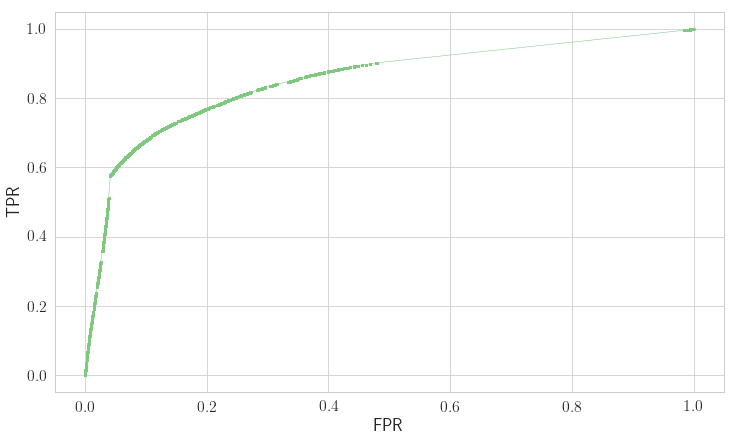

In [25]:
fig, ax, auc = plotting.plotROC(y_va, yhat_va) 

# Construct grid for subsearch

And examine results further... punish folds with large standard deviations

In [28]:
subsearch_param_grid = {
    'pca__n_components': np.array([29, 30, 31]),
    'sgd__penalty': ['l2'],
    'sgd__alpha': np.linspace(0.5, 2, 20),
    'sgd__loss': ['modified_huber']
    }  # noqa
subsearch_param_grid

{'pca__n_components': array([29, 30, 31]),
 'sgd__alpha': array([0.5       , 0.57894737, 0.65789474, 0.73684211, 0.81578947, 0.89473684, 0.97368421, 1.05263158, 1.13157895, 1.21052632, 1.28947368,
        1.36842105, 1.44736842, 1.52631579, 1.60526316, 1.68421053, 1.76315789, 1.84210526, 1.92105263, 2.        ]),
 'sgd__loss': ['modified_huber'],
 'sgd__penalty': ['l2']}

In [50]:
sidx = cvr.mean_test_score.argsort()[::-1]

mtes = cvr.mean_test_score[sidx]

stes = cvr.std_test_score[sidx]

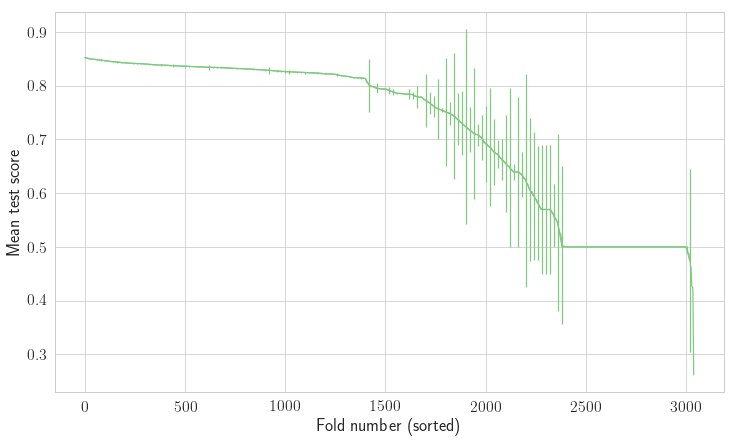

In [87]:
fig, ax = plt.subplots()
plotx = np.arange(len(mtes))
every_n = 20
ax.plot(plotx, mtes)
ax.errorbar(plotx[::every_n], mtes[::every_n], stes[::every_n], color=colorcycle[0])
ax.set_xlabel("Fold number (sorted)")
ax.set_ylabel(r"Mean test score")
fig.savefig("figs/usermovement_cv_mean_test_score.pdf") 

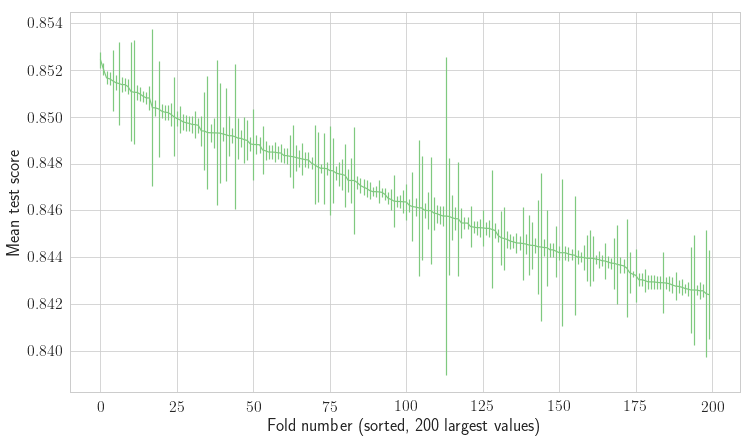

In [116]:
fig, ax = plt.subplots()
plotx = np.arange(len(mtes))
crop_n = 200
every_n = 1
# ax.plot(plotx[:crop_n], mtes[:crop_n])
ax.errorbar(plotx[:crop_n][::every_n], mtes[:crop_n][::every_n], stes[:crop_n][::every_n], color=colorcycle[0])
ax.set_xlabel(f"Fold number (sorted, {crop_n} largest values)")
ax.set_ylabel(r"Mean test score")
fig.savefig("figs/usermovement_cv_mean_test_score_crop.pdf") 

Just like the table of mean scores, make the matrix with standard deviations

In [115]:
gbus = cvr.groupby(['param_pca__n_components', 'param_sgd__alpha']).std_test_score.mean().T.unstack() 
gbus.columns.name = 'alpha'
gbus.index.name = 'pca components'
gbus.head() 

alpha,0.00390625,0.0078125,0.015625,0.03125,0.0625,...,8.0,16.0,32.0,64.0,128.0
pca components,,,,,,,,,,,
2,0.051287,0.066770,0.047373,0.063244,0.050179,...,0.022975,0.022002,0.000163,0.000186,0.000160
3,0.044953,0.039744,0.049188,0.042434,0.054344,...,0.011383,0.024632,0.000227,0.000150,0.000151
4,0.054036,0.027735,0.052286,0.034757,0.025414,...,0.016399,0.004426,0.000186,0.000140,0.000211
5,0.026558,0.039757,0.037043,0.032230,0.031378,...,0.012611,0.019958,0.000107,0.000153,0.000134
6,0.042453,0.036844,0.040945,0.041729,0.042535,...,0.021958,0.022074,0.000151,0.000168,0.000128


In [155]:
def softmax(x):
    exp_x = np.exp(x)
    if isinstance(x, pd.DataFrame):
        exp_x_sum = np.sum(exp_x.values) 
    else:
        exp_x_sum = np.sum(exp_x) 
    exp_x /= exp_x_sum
    return exp_x
    

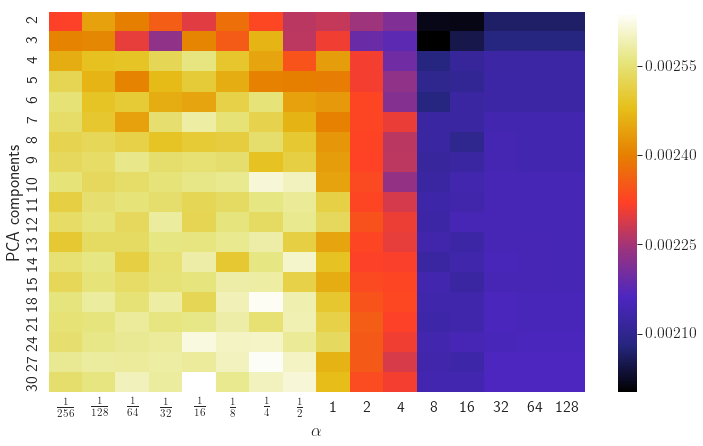

In [164]:
fig, ax = plt.subplots() 
sns.heatmap(gbu*softmax(gbus), ax=ax, cmap='CMRmap')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('PCA components') 
ax.set_xticklabels(xlabels, rotation='horizontal')
fig.savefig('figs/crossval_pca_alpha_std_softmax_weighted_cmrmap.pdf') 

# Combining the data differently

* I can simply group by quarter, and take the average, which still retains a lot of the information.
* I can use Median to maintain the binary nature of the data... how is ties resolved?
* I can remove the 0
* I can impute them using... median? MCMC?
* I can combine quarters on an hourly basis
* I can combine pr. channel, in the same way I combined on quarters, but this throws away some temporal information!

## Other ideas

Do HDB-scan and t-sne on data

In [5]:
df = pd.DataFrame(x, columns=[f"{c}{q}" for c in 'csgb' for q in range(1, 9)]) 
df.head() 

,c1,c2,c3,c4,c5,...,b4,b5,b6,b7,b8
0,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1
1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1
3,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1


In [6]:
cmb = df.groupby(df.columns.str[-1], axis=1).mean()

In [7]:
cmb.head() 

,1,2,3,4,5,6,7,8
0,-1.0,-1.0,-0.5,-0.5,-1.0,-1.0,-0.5,-1.0
1,-1.0,-1.0,-1.0,0.5,-0.5,-1.0,-1.0,0.0
2,-1.0,-1.0,-0.5,-1.0,-1.0,-0.5,-0.5,-0.5
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.0,-1.0,-0.5,-1.0,-1.0,-1.0,-0.5,-1.0


In [18]:
cmb.to_msgpack('../../allan_data/DataPredictMovement_half_quarter_comb_mean.msgpack')

Combine hourly.

In [13]:
cmb_h = df.groupby(np.roll(df.columns.str[-1].astype(int) % 4, 1) + 1, axis=1).mean()

In [14]:
cmb_h.head() 

,1,2,3,4
0,-1.00,-1.00,-0.5,-0.75
1,-0.75,-1.00,-1.0,0.25
2,-1.00,-0.75,-0.5,-0.75
3,-1.00,-1.00,-1.0,-1.00
4,-0.50,-1.00,-0.5,-1.00


In [19]:
cmb_h.to_msgpack('../../allan_data/DataPredictMovement_half_quarter_comb_hourly_mean.msgpack')

# More cv analysis

In [24]:
print(*cvr.columns, sep='\n')

mean_fit_time
mean_score_time
mean_test_score
mean_train_score
param_pca__n_components
param_sgd__alpha
param_sgd__loss
param_sgd__penalty
params
rank_test_score
split0_test_score
split0_train_score
split1_test_score
split1_train_score
split2_test_score
split2_train_score
split3_test_score
split3_train_score
std_fit_time
std_score_time
std_test_score
std_train_score


In [39]:
mask_perceptron = (cvr.param_sgd__loss == 'perceptron') 

In [44]:
cvr.filter(regex=r'split.+score$').head() 

,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score
0,0.783605,0.783395,0.783299,0.782905,0.783763,0.783679,0.782906,0.783591
1,0.783835,0.783617,0.783640,0.783245,0.783842,0.783752,0.783119,0.783807
2,0.287112,0.286859,0.277437,0.277938,0.684258,0.682537,0.703380,0.704737
3,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
4,0.785722,0.785503,0.785953,0.785565,0.785829,0.785699,0.784981,0.785705


In [48]:
est.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

# Analysis of original data: State change

Make a dataset where a change of state is indicated, not the state itself.
Is this a better predictor?

Show columns, get a groupby to work

In [28]:
for k, v in dfx.columns.groupby(dfx.columns.str[:2]).items():
    print(*v, sep='\t')

bt1	bt2	bt3	bt4	bt5	bt6	bt7	bt8
call1	call2	call3	call4	call5	call6	call7	call8
gps1	gps2	gps3	gps4	gps5	gps6	gps7	gps8
sms1	sms2	sms3	sms4	sms5	sms6	sms7	sms8


In [32]:
dfxbt = dfx.filter(regex=r'bt')

In [44]:
(dfxbt.head().diff(axis=1).iloc[:, 1:] != 0).astype(int) 

,bt2,bt3,bt4,bt5,bt6,bt7,bt8
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0


In [52]:
dfch = (dfx.groupby(dfx.columns.str[:2], axis=1).diff(axis=1).iloc[:, 1:] != 0).astype(int) 

Onehot-like encoding

In [64]:
dfch.head() 

,call2,call3,call4,call5,call6,call7,call8,sms1,sms2,sms3,...,gps7,gps8,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8
0,0,0,1,1,0,1,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,0,0,0


In [58]:
dfch.to_msgpack('../../allan_data/DataPredictMovement_change_of_movement_indicator_state.msgpack')